# **Импорт библиотек и настройка**

In [1]:
import requests
import pandas as pd
import json
import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import warnings
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

print("Библиотеки импортированы успешно!")

Библиотеки импортированы успешно!


# **Парсинг вакансий с HeadHunter API**

In [2]:
def get_vacancies(keyword, area=1, per_page=100, pages=2):
    """
    Функция для получения вакансий с hh.ru API.
    :param keyword: ключевое слово для поиска (например, "программист")
    :param area: регион (1 - Москва, 113 - Россия)
    :param per_page: количество вакансий на странице
    :param pages: количество страниц для парсинга
    :return: список вакансий
    """
    base_url = "https://api.hh.ru/vacancies"
    all_vacancies = []
    
    for page in range(pages):
        params = {
            'text': keyword,
            'area': area,
            'per_page': per_page,
            'page': page
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            vacancies = data.get('items', [])
            all_vacancies.extend(vacancies)
            
            print(f"✅ Получено {len(vacancies)} вакансий со страницы {page + 1}")
            
            time.sleep(0.5)
            
        except Exception as e:
            print(f"❌ Ошибка при получении страницы {page}: {e}")
            break
    
    return all_vacancies

# --- Запуск парсинга ---
print("🚀 Начинаем сбор данных с hh.ru...")
vacancies = get_vacancies("программист", area=113, per_page=100, pages=2) 

print(f"\n📊 Всего собрано вакансий: {len(vacancies)}")

# Проверка: если вакансий нет — не продолжаем
if len(vacancies) == 0:
    print("⚠️ Нет данных. Проверь подключение и параметры запроса.")
else:
    df_vacancies = pd.DataFrame(vacancies)

    def safe_get(obj, *keys):
        for key in keys:
            if isinstance(obj, dict) and key in obj:
                obj = obj[key]
            else:
                return None
        return obj

    df_vacancies['employer_name'] = df_vacancies['employer'].apply(lambda x: safe_get(x, 'name'))
    df_vacancies['salary_from'] = df_vacancies['salary'].apply(lambda x: safe_get(x, 'from'))
    df_vacancies['area_name'] = df_vacancies['area'].apply(lambda x: safe_get(x, 'name'))

    print("\n📌 Первые 5 вакансий:")
    print(df_vacancies[['name', 'employer_name', 'salary_from', 'area_name']].head())

🚀 Начинаем сбор данных с hh.ru...
✅ Получено 100 вакансий со страницы 1
✅ Получено 100 вакансий со страницы 2

📊 Всего собрано вакансий: 200

📌 Первые 5 вакансий:
                   name                     employer_name  salary_from  \
0        Разработчик Go                            IT_One          NaN   
1  Backend developer GO  Программный Продукт, ИТ-компания          NaN   
2      Java-разработчик          СТЭП ЛОДЖИК (STEP LOGIC)          NaN   
3        Go-разработчик             Positive Technologies          NaN   
4  Frontend-разработчик                       Optimax Dev          NaN   

  area_name  
0    Москва  
1    Москва  
2    Москва  
3    Москва  
4  Тольятти  


# **Извлечение компетенций из описаний**

In [3]:
def extract_skills_from_description(description):
    """
    Простая функция для извлечения навыков из описания.
    В реальном проекте можно использовать NLP (spaCy), но для начала — регулярные выражения.
    """
    if not description:
        return []
    
    tech_keywords = [
        'python', 'java', 'javascript', 'c++', 'c#', 'go', 'rust', 'sql', 'mysql', 'postgresql',
        'mongodb', 'docker', 'kubernetes', 'linux', 'git', 'aws', 'azure', 'gcp', 'react', 'vue',
        'angular', 'django', 'flask', 'spring', 'node.js', 'typescript', 'html', 'css', 'api',
        'rest', 'graphql', 'microservices', 'ci/cd', 'jenkins', 'pytest', 'unittest', 'pandas',
        'numpy', 'scikit-learn', 'tensorflow', 'pytorch', 'machine learning', 'data science',
        'big data', 'hadoop', 'spark', 'devops', 'agile', 'scrum', 'jira', 'trello', 'figma',
        'ui/ux', 'design', 'testing', 'qa', 'security', 'cybersecurity', 'network', 'os', 'bash', '1c'
    ]
    
    desc_lower = description.lower()
    
    found_skills = []
    for skill in tech_keywords:
        if skill in desc_lower:
            found_skills.append(skill)
    
    return list(set(found_skills))  

print("🔍 Извлекаем навыки из описаний вакансий...")

df_vacancies['skills'] = df_vacancies['snippet'].apply(lambda x: extract_skills_from_description(x.get('requirement', '')) if isinstance(x, dict) else [])

all_skills = [skill for skills_list in df_vacancies['skills'] for skill in skills_list]

# Подсчитываем частоту каждого навыка
skill_counter = Counter(all_skills)
print(f"\n📈 Топ-10 самых востребованных навыков:")
for skill, count in skill_counter.most_common(10):
    print(f"   • {skill}: {count} вакансий")

df_skills = pd.DataFrame(skill_counter.most_common(), columns=['Навык', 'Частота'])
print("\n📋 Таблица всех навыков:")
print(df_skills.head(15))

🔍 Извлекаем навыки из описаний вакансий...

📈 Топ-10 самых востребованных навыков:
   • java: 54 вакансий
   • react: 33 вакансий
   • api: 32 вакансий
   • python: 30 вакансий
   • go: 29 вакансий
   • typescript: 27 вакансий
   • sql: 27 вакансий
   • git: 25 вакансий
   • javascript: 24 вакансий
   • css: 23 вакансий

📋 Таблица всех навыков:
         Навык  Частота
0         java       54
1        react       33
2          api       32
3       python       30
4           go       29
5   typescript       27
6          sql       27
7          git       25
8   javascript       24
9          css       23
10        html       19
11          os       18
12        rest       15
13      spring       13
14  postgresql       11


# **Сравнение с компетенциями УрФУ**

In [4]:
urfu_competencies = [
    # Языки и фреймворки
    'python', 'java', 'kotlin', 'javascript', 'typescript', 'sql',
    # Backend
    'fastapi', 'spring', 'django', 'sqlalchemy', 'postgresql', 'mysql', 'airflow',
    # Frontend
    'react', 'redux toolkit', 'css', 'html', 'vite', 'fsd',
    # Мобильная разработка
    'android', 'jetpack compose',
    # DevOps / CI/CD
    'git', 'github', 'docker', 'github actions', 'ci/cd',
    # Дизайн
    'figma', 'ui/ux design', 'material design', 'prototyping',
    # Тестирование
    'testing', 'qa', 'mock service worker', 'unit tests', 'junit',
    # Управление
    'agile', 'scrum', 'product thinking', 'requirements analysis',
    'technical specification', 'mvp', 'youtrack', 'jira',
    # Аналитика / API / Безопасность
    'data analysis', 'dashboards', 'apache superset', 'reporting',
    'api', 'rest', 'security',
    # ERP / 1С
    '1c:erp', 'production planning', 'resource allocation',
    # Арт / геймдев
    '2d art', 'vector graphics', 'character design', 'background art',
    'sprite atlas', 'game ui'
]

print("📚 Компетенции программы УрФУ:")
print(", ".join(urfu_competencies))

def normalize(skill):
    skill = skill.lower().strip()
    aliases = {
        'redux toolkit': 'redux',
        'jetpack compose': 'compose',
        'material design': 'material',
        'ui/ux design': 'ui',
        'technical specification': 'specification',
        'production planning': 'planning',
        'resource allocation': 'allocation',
        'product thinking': 'product',
        'vector graphics': 'vector',
        'character design': 'character',
        'background art': 'background',
        'sprite atlas': 'atlas',
        'game ui': 'game ui',
        'mock service worker': 'msw',
        'github actions': 'github actions',
        'apache superset': 'superset',
        '1c:erp': '1c',
        'spring': 'spring', 
        'junit': 'junit'     
    }
    return aliases.get(skill, skill)

norm_urfu = {normalize(c) for c in urfu_competencies}
norm_industry = {normalize(s) for s in skill_counter.keys()}

industry_only = norm_industry - norm_urfu
program_only = norm_urfu - norm_industry

print(f"\n⚠️ Навыки, востребованные в индустрии, но отсутствующие в программе ({len(industry_only)}):")
print(", ".join(sorted(industry_only)) if industry_only else "— Нет таких навыков — программа в тренде")

print(f"\n📉 Навыки, изучаемые в программе, но слабо востребованные в индустрии ({len(program_only)}):")
print(", ".join(sorted(program_only)) if program_only else "— Все компетенции актуальны!")


matrix_rows = []
for comp in urfu_competencies:
    norm = normalize(comp)
    in_industry = norm in norm_industry
    freq = skill_counter.get(norm, 0)
    if not in_industry:
        freq = sum(count for sk, count in skill_counter.items() if norm in sk.lower())
        in_industry = freq > 0
    matrix_rows.append({
        'Компетенция': comp,
        'Есть в индустрии': in_industry,
        'Частота в индустрии': freq
    })

df_matrix = pd.DataFrame(matrix_rows)
df_matrix = df_matrix.sort_values('Частота в индустрии', ascending=False)

📚 Компетенции программы УрФУ:
python, java, kotlin, javascript, typescript, sql, fastapi, spring, django, sqlalchemy, postgresql, mysql, airflow, react, redux toolkit, css, html, vite, fsd, android, jetpack compose, git, github, docker, github actions, ci/cd, figma, ui/ux design, material design, prototyping, testing, qa, mock service worker, unit tests, junit, agile, scrum, product thinking, requirements analysis, technical specification, mvp, youtrack, jira, data analysis, dashboards, apache superset, reporting, api, rest, security, 1c:erp, production planning, resource allocation, 2d art, vector graphics, character design, background art, sprite atlas, game ui

⚠️ Навыки, востребованные в индустрии, но отсутствующие в программе (12):
angular, c#, c++, flask, go, graphql, kubernetes, linux, mongodb, os, pytorch, vue

📉 Навыки, изучаемые в программе, но слабо востребованные в индустрии (37):
1c, 2d art, airflow, allocation, android, atlas, background, character, compose, dashboards, d

# **Визуализация и аналитический отчёт**

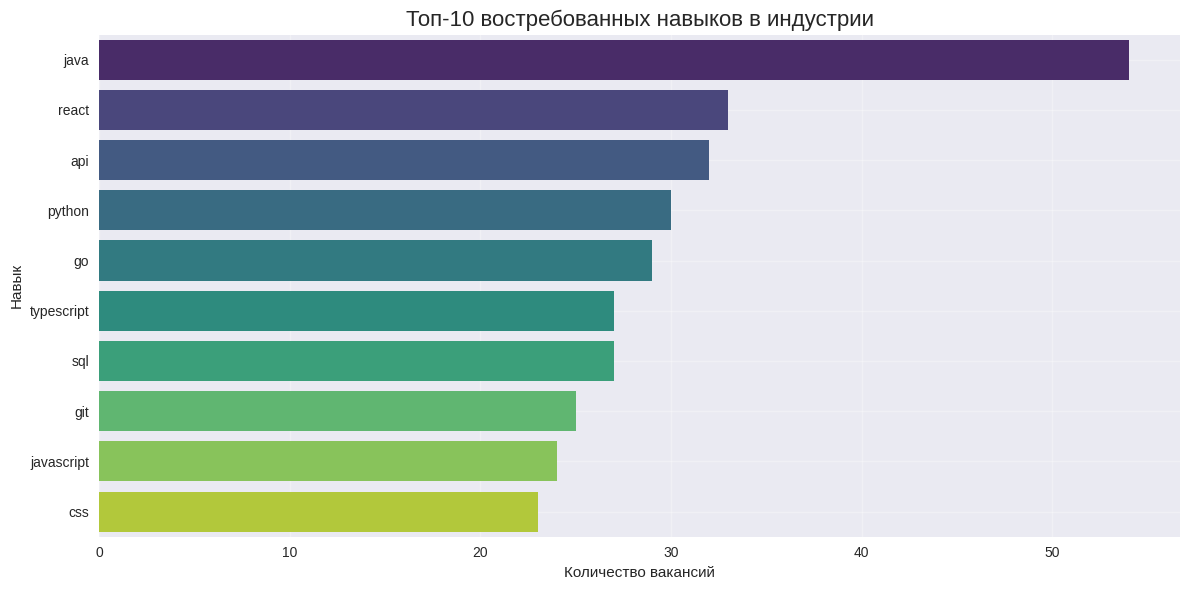

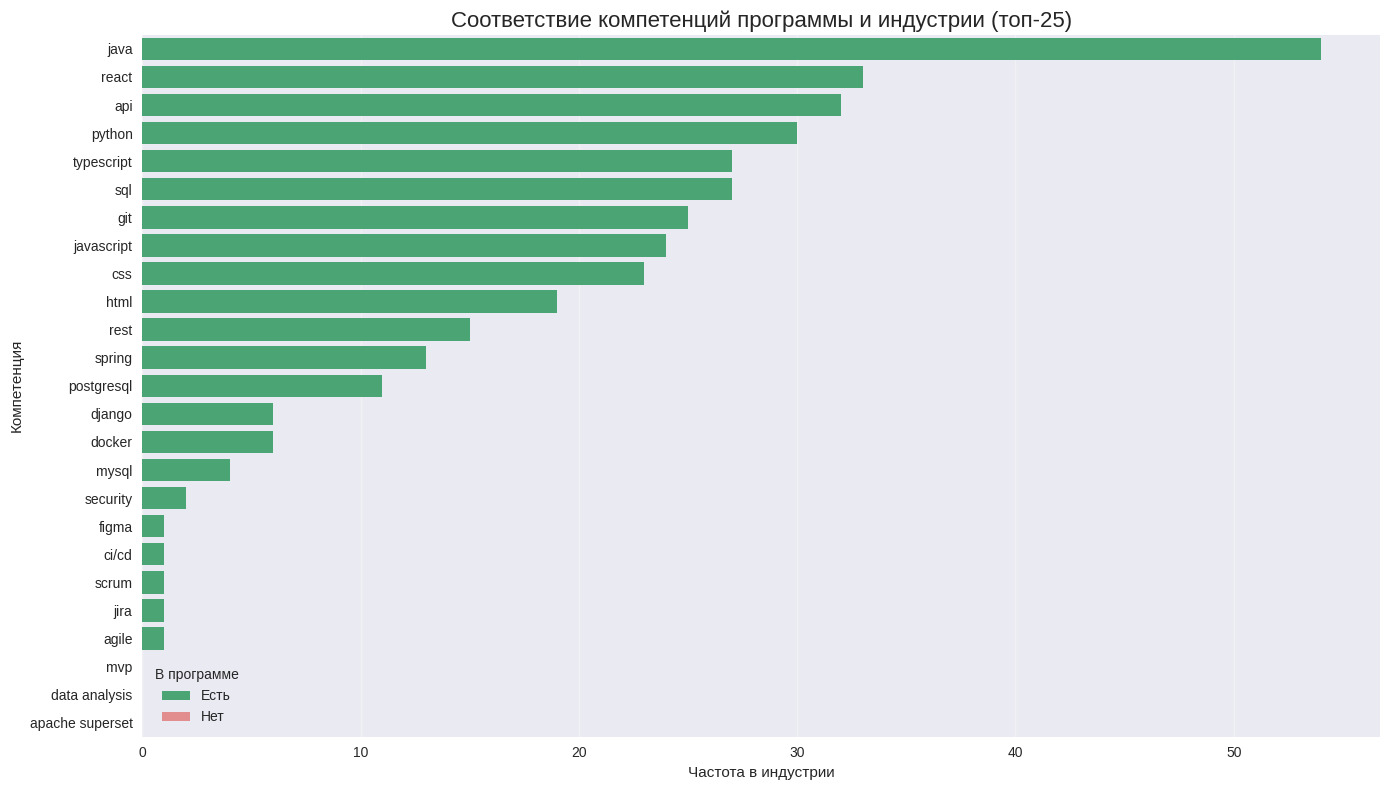

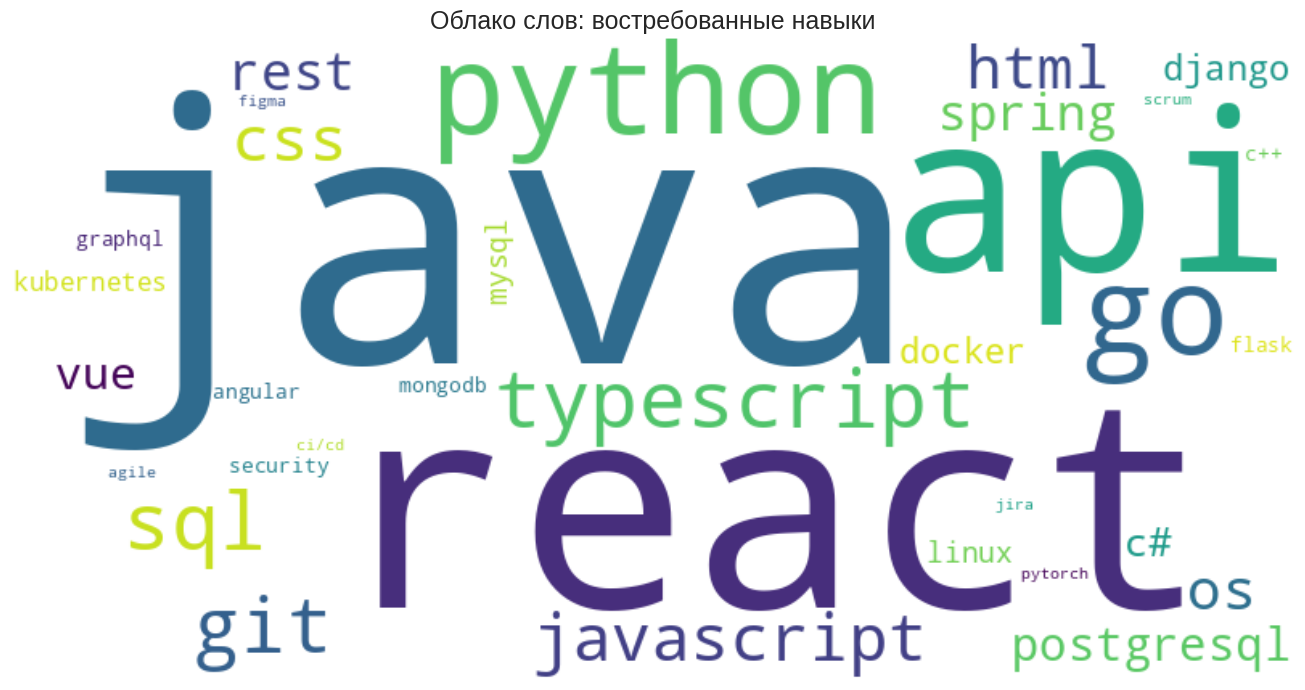

📊 АНАЛИТИЧЕСКИЙ ОТЧЕТ ПО ФАЗЕ 1

🔹 Общее количество собранных вакансий: 200
🔹 Количество уникальных навыков, найденных в индустрии: 34
🔹 Топ-3 навыка: java, react, api

🔹 Компетенции программы УрФУ: 59
🔹 Навыки, которых нет в программе, но востребованы: 12
🔹 Навыки, которые есть в программе, но редки в индустрии: 37

💡 РЕКОМЕНДАЦИИ:
   • Добавить в программу: angular, c#, c++, flask, go
   • Пересмотреть актуальность (для общего ядра): 1c, 2d art, airflow, allocation, android
     → Эти компетенции лучше вынести в специализированные треки (геймдев, ERP, и т.д.)

✅ Фаза 1 завершена. Артефакт 'Стратегический Профиль Партнера' готов.


In [5]:
plt.style.use('seaborn-v0_8') 
sns.set_palette("husl")

# --- График 1: Топ-10 навыков ---
plt.figure(figsize=(12, 6))
top_skills = df_skills.head(10)
sns.barplot(data=top_skills, x='Частота', y='Навык', palette='viridis')
plt.title('Топ-10 востребованных навыков в индустрии', fontsize=16)
plt.xlabel('Количество вакансий')
plt.ylabel('Навык')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- График 2: Соответствие компетенций ---
df_plot = df_matrix.head(25).copy()
df_plot['Цвет'] = df_plot['Есть в индустрии'].map({True: 'Есть', False: 'Нет'})

plt.figure(figsize=(14, 8))
sns.barplot(data=df_plot, x='Частота в индустрии', y='Компетенция', hue='Цвет',
            dodge=False, palette={'Есть': 'mediumseagreen', 'Нет': 'lightcoral'})
plt.title('Соответствие компетенций программы и индустрии (топ-25)', fontsize=16)
plt.xlabel('Частота в индустрии')
plt.ylabel('Компетенция')
plt.grid(True, axis='x', alpha=0.3)
plt.legend(title='В программе')  
plt.tight_layout()
plt.show()

# --- Облако слов ---
if skill_counter:
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis') \
                  .generate_from_frequencies(skill_counter)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов: востребованные навыки', fontsize=18)
    plt.tight_layout()
    plt.show()

# --- Аналитический отчёт ---
print("="*80)
print("📊 АНАЛИТИЧЕСКИЙ ОТЧЕТ ПО ФАЗЕ 1")
print("="*80)

print(f"\n🔹 Общее количество собранных вакансий: {len(vacancies)}")
print(f"🔹 Количество уникальных навыков, найденных в индустрии: {len(skill_counter)}")
print(f"🔹 Топ-3 навыка: {', '.join([x[0] for x in skill_counter.most_common(3)])}")

print(f"\n🔹 Компетенции программы УрФУ: {len(urfu_competencies)}")
print(f"🔹 Навыки, которых нет в программе, но востребованы: {len(industry_only)}")
print(f"🔹 Навыки, которые есть в программе, но редки в индустрии: {len(program_only)}")

print("\n💡 РЕКОМЕНДАЦИИ:")
if len(industry_only) > 0:
    top_missing = sorted(industry_only)[:5]
    print(f"   • Добавить в программу: {', '.join(top_missing)}")
if len(program_only) > 0:
    top_excess = sorted(program_only)[:5]
    print(f"   • Пересмотреть актуальность (для общего ядра): {', '.join(top_excess)}")
    print("     → Эти компетенции лучше вынести в специализированные треки (геймдев, ERP, и т.д.)")

print(f"\n✅ Фаза 1 завершена. Артефакт 'Стратегический Профиль Партнера' готов.")

# **ФАЗА 2: ФОРМИРОВАНИЕ ПУЛА И СКОРИНГ**

In [6]:
# Получаем уникальные ID работодателей
employer_ids = df_vacancies['employer'].apply(
    lambda x: x.get('id') if isinstance(x, dict) and x.get('id') else None
).dropna().unique()

print(f"🔍 Будет загружено до {min(100, len(employer_ids))} профилей компаний...")

🔍 Будет загружено до 100 профилей компаний...


In [7]:
def get_employer_details(emp_id):
    try:
        resp = requests.get(f"https://api.hh.ru/employers/{emp_id}", timeout=5)
        if resp.status_code == 200:
            return resp.json()
    except Exception as e:
        pass
    return None

employer_profiles = []
for eid in list(employer_ids)[:100]:
    profile = get_employer_details(eid)
    if profile:
        employer_profiles.append(profile)
    time.sleep(0.3)

df_companies = pd.DataFrame(employer_profiles)
print(f"✅ Загружено {len(df_companies)} профилей компаний.")

✅ Загружено 100 профилей компаний.


In [8]:
def calculate_score(row, urfu_set):
    score = 0
    descr = str(row.get('description', ''))
    
    # Технологии
    skills = extract_skills_from_description(descr)
    matched = len({normalize(s) for s in skills} & urfu_set)
    score += min(40, matched * 3)
    
    # Масштаб (по числу открытых вакансий как proxy)
    open_vac = row.get('open_vacancies', 0)
    if open_vac > 20: score += 25
    elif open_vac > 10: score += 20
    elif open_vac > 0: score += 15
    else: score += 10
    
    # Регион: Свердловская область?
    area_info = row.get('area')
    if area_info and isinstance(area_info, dict):
        area_name = area_info.get('name', '').lower()
        if 'екатеринбург' in area_name or 'свердлов' in area_name:
            score += 5
    
    # Опыт в образовании
    edu_keywords = ['стажировка', 'вуз', 'студент', 'образование', 'наставничество']
    if any(kw in descr.lower() for kw in edu_keywords):
        score += 15
        
    return min(100, int(score))

df_companies['score'] = df_companies.apply(lambda row: calculate_score(row, norm_urfu), axis=1)
df_companies = df_companies.sort_values('score', ascending=False).reset_index(drop=True)

In [9]:
# Подготовка читаемых полей
df_companies['area_name'] = df_companies['area'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else str(x) if x else "—"
)

df_companies['vacancies_url'] = df_companies['id'].apply(
    lambda emp_id: f"https://hh.ru/vacancies/{emp_id}" if emp_id else "—"
)

# Экспорт Top-20 для верификации
top_20 = df_companies.head(20)[[
    'name', 'score', 'site_url', 'description', 'area_name', 'vacancies_url'
]].copy()

# Добавляем колонки для человека
top_20['include_in_shortlist'] = True
top_20['comments'] = ""

# Создаём папку, если не существует
import os
os.makedirs("templates", exist_ok=True)

# Сохраняем
top_20.to_excel("templates/top_20_companies_for_review.xlsx", index=False)
print("✅ Файл для верификации сохранён: templates/top_20_companies_for_review.xlsx")
print("📄 Откройте Excel, отметьте нужные компании (include_in_shortlist = True) и сохраните как top_10_verified.xlsx")

✅ Файл для верификации сохранён: templates/top_20_companies_for_review.xlsx
📄 Откройте Excel, отметьте нужные компании (include_in_shortlist = True) и сохраните как top_10_verified.xlsx


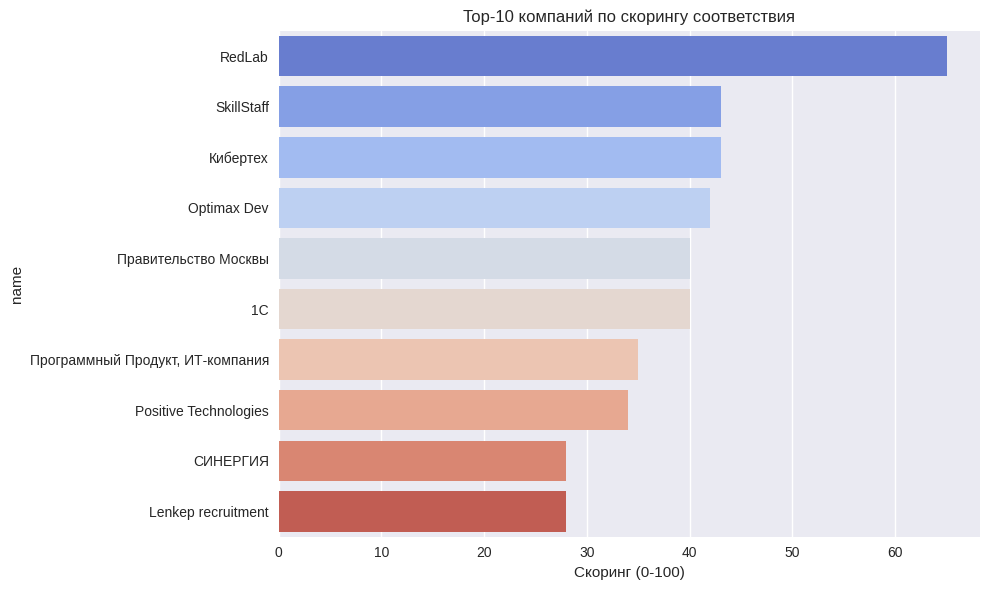

In [10]:
# Опционально: визуализация Top-10
plt.figure(figsize=(10, 6))
sns.barplot(data=df_companies.head(10), x='score', y='name', palette='coolwarm')
plt.title('Top-10 компаний по скорингу соответствия')
plt.xlabel('Скоринг (0-100)')
plt.tight_layout()
plt.show()

# **ФАЗА 3: СТРАТЕГИЧЕСКАЯ КОММУНИКАЦИЯ**

In [11]:
# Формат: 'Каноническое Имя': [список вариаций для regex]
TECH_ALIASES = {
    '1C': [r'1c', r'1с', r'1с-битрикс', r'bitrix', r'битрикс'], # Латиница и Кириллица
    'PHP': [r'php', r'laravel', r'symfony', r'yii'],
    'JavaScript': [r'js', r'javascript', r'es6\+', r'front-end', r'frontend'],
    'React': [r'react', r'react\.js', r'reactjs'],
    'React Native': [r'react native', r'rn'],
    'Java': [r'java', r'jvm', r'spring', r'hibernate'], # Исключаем javascript через lookbehind/lookahead в коде ниже
    'Python': [r'python', r'django', r'flask', r'fastapi', r'pandas'],
    'C++': [r'c\+\+'],
    'C#': [r'c#', r'\.net', r'dotnet', r'c sharp'],
    'Go': [r'golang', r'go\s?lang'], # Просто "go" искать опасно, найдет в слове "google"
    'SQL': [r'sql', r'mysql', r'postgresql', r'postgres', r'oracle', r'pl/sql'],
    'DevOps': [r'devops', r'docker', r'k8s', r'kubernetes', r'jenkins', r'ci/cd', r'gitlab'],
    'TypeScript': [r'typescript', r'ts'],
    'Redux': [r'redux', r'mobx', r'rtk', r'redux-toolkit'],
    'Git': [r'git', r'github', r'gitlab']
}

# Добавляем компетенции ВУЗа, которых нет в словаре, как простые ключи
for skill in urfu_competencies:
    norm_skill = skill.lower().strip()
    # Если навыка еще нет в ключах и значениях, добавляем
    found = False
    for k, v in TECH_ALIASES.items():
        if norm_skill == k.lower() or norm_skill in v:
            found = True
            break
    if not found:
        TECH_ALIASES[skill.capitalize()] = [re.escape(norm_skill)]

In [12]:
def clean_html(raw_html):
    if not isinstance(raw_html, str): return ""
    # Удаляем HTML теги, оставляя пробелы, чтобы слова не слиплись (<li>Java</li><li>PHP</li> -> Java PHP)
    return BeautifulSoup(raw_html, "lxml").get_text(separator=" ") 

def extract_skills_advanced(text):
    if not text: return []
    
    # 1. Очистка
    clean_text = clean_html(text).lower()
    
    # 2. Замена частых разделителей на пробелы для упрощения поиска
    # Заменяем слэши, скобки и запятые на пробелы
    clean_text = re.sub(r'[\/\(\),;]', ' ', clean_text)
    
    found_skills = set()
    
    for category, patterns in TECH_ALIASES.items():
        for pattern in patterns:
            # СТРОГИЙ ПОИСК:
            # Ищем совпадение, но следим, чтобы это было отдельное слово.
            # (?:^|\s) - начало строки или пробел перед словом
            # (?:$|\s) - конец строки или пробел после слова
            # Это спасет от нахождения "Go" внутри "Google" или "Java" внутри "JavaScript"
            
            # Нюанс для C++ и C# (спецсимволы)
            if '+' in pattern or '#' in pattern or '.' in pattern:
                 # Для символьных паттернов просто ищем вхождение с границами
                 regex = r'(?:^|\s)' + pattern + r'(?:$|\s)'
            else:
                 # Для буквенных используем границы слова \b (работает для латиницы)
                 # Но для кириллицы (1С) лучше использовать пробельные границы
                 regex = r'(?:^|\s)' + pattern + r'(?:$|\s)'
            
            if re.search(regex, clean_text):
                found_skills.add(category) # Добавляем КАТЕГОРИЮ (например, нашли Laravel -> записали PHP)
                break # Если нашли Laravel, не обязательно искать PHP, категория уже засчитана
                
    return list(found_skills)

In [13]:
# Настройки
INPUT_FILE = "templates/top_20_companies_for_review.xlsx"
OUTPUT_DIR = "communication_packages"
ASSETS_DIR = os.path.join(OUTPUT_DIR, "assets")
os.makedirs(ASSETS_DIR, exist_ok=True)

# ==========================================
# КОНТЕНТ (Задача 3.2: Материалы)
# ==========================================

FAQ_CONTENT = """
# FAQ для партнеров программы "ПроКомпетенции"

Q: Нужно ли нам платить студентам?
A: Нет, в рамках учебного модуля практика неоплачиваемая. Однако, если студент показывает выдающиеся результаты, вы можете предложить ему оффер.

Q: Кто владеет правами на код (IP)?
A: По умолчанию права остаются у авторов (студентов), но мы подписываем соглашение об отчуждении прав в пользу компании-партнера до старта работ.

Q: Сколько времени наши менторы должны тратить на студентов?
A: Мы рекомендуем выделять 2 часа в неделю на синхронизацию (demo) и код-ревью.

Q: Что если студенты не справятся?
A: Это учебный процесс. Мы не гарантируем production-ready результат, но наши кураторы со стороны ВУЗа следят за качеством. Вы ничего не теряете.
"""

AGREEMENT_TEMPLATE = """
# СОГЛАШЕНИЕ О ПАРТНЕРСТВЕ (ШАБЛОН)

Стороны: Университет УрФУ и Компания "{company_name}"
Предмет: Организация проектного практикума.

1. Компания предоставляет ТЗ на разработку модуля с использованием стека: {tech_stack}.
2. Университет выделяет команду из 3-5 студентов.
3. Срок реализации: 3 месяца.
4. Результат работ передается Компании по акту приема-передачи.
"""

PRESENTATION_STRUCTURE = """
# СТРУКТУРА ПРЕЗЕНТАЦИИ ДЛЯ {company_name}

Слайд 1: Титульный
- Заголовок: Кадровый резерв для {company_name}
- Подзаголовок: Проектное обучение УрФУ

Слайд 2: Проблема
- Поиск Junior-разработчиков дорогой и долгий.
- Вы тратите ресурсы Senior-ов на онбординг.

Слайд 3: Наше решение
- Команда студентов уже знает {top_tech}.
- Они делают ваши задачи из бэклога в рамках учебы.

Слайд 4: Выгода для {company_name}
- 0 рублей затрат на поиск.
- Решение задач, до которых не доходят руки.
- Тест-драйв будущих сотрудников.
"""

# ==========================================
# ШАБЛОНЫ ПИСЕМ (Задача 3.1: Разные тона)
# ==========================================

TEMPLATE_FORMAL = """
Тема: Подготовка кадров ({tech_stack}) для {company_name}
Уважаемые коллеги,
Меня зовут [Имя], я координирую проектное обучение в УрФУ.
Мы видим, что вы развиваете продукты на {top_tech}. У нас есть сформированные студенческие команды, готовые выполнить для вас проектную задачу на этом стеке.
Прилагаю презентацию и ответы на частые вопросы.
Готов обсудить детали звонком во вторник или четверг.
С уважением,
Агент ПроКомпетенции
"""

TEMPLATE_INFORMAL = """
Тема: Студенты-разработчики ({top_tech}) для команды {company_name}
Привет!
Вижу, вы активно используете {top_tech}. У нас в УрФУ есть крутые студенческие команды, которые уже пишут на этом стеке.
Предлагаю запартнериться: вы даете задачу из бэклога, студенты её пилят под вашим присмотром.
Вам — закрытые задачи и присмотр за джунами без HR-расходов. Нам — практика.
Как смотрите на то, чтобы созвониться на 10 минут?
"""

# ==========================================
# СЦЕНАРИИ ОТВЕТОВ (Задача 3.3)
# ==========================================

SCENARIOS_CONTENT = """
# СЦЕНАРИИ ОБРАБОТКИ ОТВЕТОВ

1. Если ответили "ИНТЕРЕСНО":
   -> Действие: Предложить слоты для Zoom (Вт/Чт).
   -> Отправить: Презентацию и шаблон ТЗ.

2. Если ответили "НЕТ ВРЕМЕНИ":
   -> Действие: Предложить "Пассивный формат" (студенты делают проект по открытым данным, вы только оцениваете финал).

3. Если ответили "У НАС СВОЯ СТАЖИРОВКА":
   -> Действие: Предложить интегрировать нашу команду в их воронку отбора (фаст-трек).
"""

# ==========================================
# ЛОГИКА
# ==========================================

def extract_top_skills(description):
    if not isinstance(description, str): return "Python, SQL"
    found = extract_skills_advanced(description)
    return ", ".join(found[:3]) if found else "современный стек"

def generate_schedule(start_date=None):
    if not start_date: start_date = datetime.now()
    while start_date.weekday() in [4, 5, 6]: start_date += timedelta(days=1)

    send_date = start_date.replace(hour=10, minute=0)
    return send_date.strftime("%Y-%m-%d %H:%M")

def main():
    print("🚀 Старт Фазы 3: Стратегическая коммуникация...")

    if not os.path.exists(INPUT_FILE):
        print(f"❌ Файл {INPUT_FILE} не найден. Выполни Фазу 2.")
        return

    df = pd.read_excel(INPUT_FILE)
    if 'include_in_shortlist' not in df.columns: df['include_in_shortlist'] = True
    targets = df[df['include_in_shortlist'] == True].copy()

    if targets.empty:
        print("⚠️ Список рассылки пуст. Проверь колонку include_in_shortlist.")
        return

    schedule_data = []

    for idx, row in targets.iterrows():
        company = row['name']
        desc = row.get('description', '')
        tech = extract_top_skills(desc)
        top_tech = tech.split(',')[0] if tech else "IT"

        # 1. Генерация ДВУХ вариантов писем (Задача 3.1)
        email_formal = TEMPLATE_FORMAL.format(company_name=company, tech_stack=tech, top_tech=top_tech)
        email_informal = TEMPLATE_INFORMAL.format(company_name=company, top_tech=top_tech)

        # 2. Материалы (Задача 3.2)
        comp_clean = "".join(x for x in company if x.isalnum())[:50]
        safe_filename = f"{idx}_{comp_clean}"

        with open(f"{ASSETS_DIR}/{safe_filename}_pres.md", "w", encoding="utf-8") as f:
            f.write(PRESENTATION_STRUCTURE.format(company_name=company, top_tech=top_tech))

        with open(f"{ASSETS_DIR}/{safe_filename}_agree.md", "w", encoding="utf-8") as f:
            f.write(AGREEMENT_TEMPLATE.format(company_name=company, tech_stack=tech))

        # 3. Планирование (Задача 3.3)
        send_dt = generate_schedule()

        schedule_data.append({
            'Company': company,
            'Tech_Focus': tech,
            'Email_Draft_Formal': email_formal.strip(),
            'Email_Draft_Informal': email_informal.strip(), # Добавили неформальный вариант
            'Planned_Send_Date': send_dt,
            'Assets_Link': safe_filename
        })

    # Сохраняем общие материалы
    with open(f"{OUTPUT_DIR}/GENERAL_FAQ.md", "w", encoding="utf-8") as f:
        f.write(FAQ_CONTENT)

    with open(f"{OUTPUT_DIR}/RESPONSE_SCENARIOS.md", "w", encoding="utf-8") as f: # Новое требование
        f.write(SCENARIOS_CONTENT)

    # Итоговая таблица
    df_res = pd.DataFrame(schedule_data)
    df_res.to_excel(f"{OUTPUT_DIR}/communication_plan_final.xlsx", index=False)

    print(f"✅ Фаза 3 завершена. Артефакты созданы.")
    print(f"📊 Обработано компаний: {len(df_res)}")
    print(f"📂 План и черновики: {OUTPUT_DIR}/communication_plan_final.xlsx")
    print(f"📂 Сценарии ответов: {OUTPUT_DIR}/RESPONSE_SCENARIOS.md")

if __name__ == "__main__":
    main()

🚀 Старт Фазы 3: Стратегическая коммуникация...
✅ Фаза 3 завершена. Артефакты созданы.
📊 Обработано компаний: 20
📂 План и черновики: communication_packages/communication_plan_final.xlsx
📂 Сценарии ответов: communication_packages/RESPONSE_SCENARIOS.md


## ФАЗА 4: OUTREACH И КВАЛИФИКАЦИЯ (симуляция)

In [14]:
import random
from datetime import datetime, timedelta

# ---------------------------------------------------------
# КОНФИГУРАЦИЯ
# ---------------------------------------------------------
INPUT_FILE = "communication_packages/communication_plan_final.xlsx"
OUTPUT_DIR = "communication_packages/phase4_simulation"
THREADS_DIR = os.path.join(OUTPUT_DIR, "threads")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(THREADS_DIR, exist_ok=True)

# ---------------------------------------------------------
# СКРИПТОВЫЕ СЦЕНАРИИ ОТВЕТОВ
# ---------------------------------------------------------

RESPONSE_TYPES = {
    "INTEREST": {
        "weight": 0.25,
        "text": "Здравствуйте! Спасибо за письмо. Нам интересно обсудить участие. Предложите слот на встречу."
    },
    "NO_TIME": {
        "weight": 0.30,
        "text": "Коллеги, спасибо. Сейчас у нас нет времени на менторство."
    },
    "OWN_INTERNSHIP": {
        "weight": 0.20,
        "text": "Спасибо! У нас есть собственная стажировка, мы обычно в неё погружаем ребят."
    },
    "DECLINE": {
        "weight": 0.25,
        "text": "Спасибо, но нам не подходит участие в подобных форматах."
    }
}

# Ответы агента согласно SCENARIOS_CONTENT
AGENT_RESPONSE_MAP = {
    "INTEREST": "Спасибо! Предлагаю провести короткий Zoom-звонок. Доступные слоты: вторник 11:00, четверг 15:00.\nПрикладываю презентацию и шаблон ТЗ.",
    "NO_TIME": "Понимаю! Можем предложить пассивный формат — студенты выполняют проект по открытым данным, а вы лишь оцениваете итог.",
    "OWN_INTERNSHIP": "Тогда можем встроить наших лучших студентов в ваш фаст-трек. Они решат одно тестовое задание и сразу пойдут на финал.",
    "DECLINE": "Спасибо за ответ! Если ситуация изменится — мы всегда на связи."
}

# ---------------------------------------------------------
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# ---------------------------------------------------------

def pick_response_type():
    r = random.random()
    cumulative = 0
    for k, v in RESPONSE_TYPES.items():
        cumulative += v["weight"]
        if r <= cumulative:
            return k
    return "DECLINE"

def simulate_dates(base_date):
    send_dt = datetime.strptime(base_date, "%Y-%m-%d %H:%M")
    reply_dt = send_dt + timedelta(hours=random.randint(10, 120))
    followup_dt = send_dt + timedelta(days=random.randint(7, 14))
    return send_dt, reply_dt, followup_dt

# ---------------------------------------------------------
# ОСНОВНАЯ ЛОГИКА
# ---------------------------------------------------------

def run_phase4_simulation():

    if not os.path.exists(INPUT_FILE):
        print(f"Файл {INPUT_FILE} не найден. Надо сначала прогнать Фазу 3.")
        return

    df = pd.read_excel(INPUT_FILE)
    results = []

    print("🚀 ФАЗА 4: Симуляция Outreach и квалификации...")

    for idx, row in df.iterrows():
        company = row["Company"]
        tech = row["Tech_Focus"]
        formal = row["Email_Draft_Formal"]
        informal = row["Email_Draft_Informal"]
        send_date = row["Planned_Send_Date"]
        asset_key = row["Assets_Link"]

        thread_path = f"{THREADS_DIR}/{idx}_{company.replace(' ','_')}.txt"
        response_type = pick_response_type()

        send_dt, reply_dt, followup_dt = simulate_dates(send_date)

        # Формирование диалога
        with open(thread_path, "w", encoding="utf-8") as f:
            f.write(f"==== OUTREACH SIMULATION THREAD ====\n")
            f.write(f"Компания: {company}\n")
            f.write(f"Дата отправки: {send_dt}\n\n")

            f.write("----- Письмо агента -----\n")
            f.write(formal + "\n\n")

            f.write(f"----- Ответ компании ({response_type}) -----\n")
            f.write(RESPONSE_TYPES[response_type]["text"] + "\n")
            f.write(f"Дата ответа: {reply_dt}\n\n")

            f.write("----- Ответ агента -----\n")
            f.write(AGENT_RESPONSE_MAP[response_type] + "\n\n")

            if response_type == "INTEREST":
                f.write(">>> ⚠️ Критическая точка эскалации №4: подключение человека.\n")

            f.write("\n===== END THREAD =====")
            
        results.append({
            "Company": company,
            "Initial_Send": send_dt,
            "Reply_Date": reply_dt,
            "Followup_Date": followup_dt,
            "Response_Type": response_type,
            "Human_Involved": response_type == "INTEREST",
            "Thread_File": thread_path
        })

    df_res = pd.DataFrame(results)
    df_res.to_excel(f"{OUTPUT_DIR}/phase4_simulated_results.xlsx", index=False)

    print(f"🎉 Фаза 4 завершена.")
    print(f"📁 Результаты: {OUTPUT_DIR}/phase4_simulated_results.xlsx")
    print(f"💬 Диалоги: {THREADS_DIR}/")

run_phase4_simulation()

🚀 ФАЗА 4: Симуляция Outreach и квалификации...
🎉 Фаза 4 завершена.
📁 Результаты: communication_packages/phase4_simulation/phase4_simulated_results.xlsx
💬 Диалоги: communication_packages/phase4_simulation/threads/
